In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib, json

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/orenpoleshuckkinel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Introduction to Networkx

The simple methods '.nodes()' and '.edges()' print the key components of the network.

In [2]:
HG = nx.house_graph()
HG.nodes()
HG.edges()

NodeView((0, 1, 2, 3, 4))

EdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

## Drawing the network

To draw the network, we need to give it a dictionary that maps each node to an X-Y coordinate. I give one below.

{0: Text(0, 0, '0'),
 1: Text(1, 0, '1'),
 2: Text(0, 1, '2'),
 3: Text(1, 1, '3'),
 4: Text(0.5, 2.0, '4')}

(-0.10500000000000001, 1.105, -0.21000000000000002, 2.21)

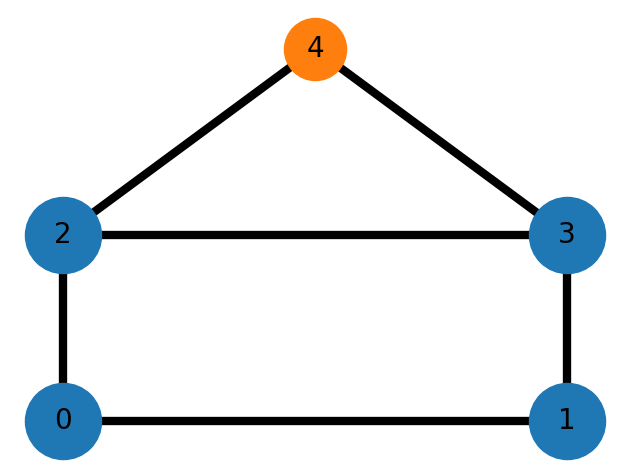

In [3]:
pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2.0)}

nx.draw_networkx_nodes(
    HG, pos, node_size=3000, nodelist=[0, 1, 2, 3], 
    node_color="tab:blue"
)

nx.draw_networkx_nodes(HG, pos, node_size=2000, 
                       nodelist=[4], node_color="tab:orange")

nx.draw_networkx_edges(HG, pos, alpha=1, width=6)
nx.draw_networkx_labels(HG, pos, font_size=20)
plt.tight_layout()
plt.axis("off")

In [4]:
ADJ = nx.to_pandas_adjacency(HG)
ADJ = ADJ.astype(bool)

In [5]:
deg_0 = nx.degree(HG, 0) 
deg_0

2

# Activity
We will learn how to process a dataframe into a useable edgelist to feed into a graph.

In [6]:
df = pd.read_pickle("../public_data/Raw_Tweets.pkl") # Load your tweets
df.head()
df.shape

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


(59887, 15)

### 1.1 Subset the dataframe to network data

- First, using .value_counts(), identify how many types of tweets there are, using the tweet_type column. 
- Then, filter out all tweets that are not "retweeted_tweet_without_comment" and "quoted_tweet."

In [7]:
# your code here
df.tweet_type.value_counts()
df = df[(df['tweet_type'] == 'retweeted_tweet_without_comment') | (df['tweet_type'] == 'quoted_tweet')]

tweet_type
original                           26275
retweeted_tweet_without_comment    19923
reply                               7292
quoted_tweet                        6397
Name: count, dtype: int64

In [8]:
## Run this. Why is it empty?
df[(df.tweet_type == "retweeted_tweet_without_comment") & (df.tweet_type == "quoted_tweet")]

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid


### 1.2 Create an edgelist

The "userid" column shows the person that did the retweeting. Create a new column called "userid2" that denotes the user retweeted. You will need to use the columns "rt_userid" and "qtd_userid."

In [9]:
df['userid2'] = df['rt_userid'].fillna(df['qtd_userid'])
df.userid2

12221     9.200360e+17
25575     1.697808e+09
28489     9.200360e+17
28496     1.661606e+07
12992     1.965894e+07
              ...     
178123    6.841204e+07
71249     4.496188e+07
111383    1.615192e+07
159487    1.465700e+08
166622    3.762414e+09
Name: userid2, Length: 26320, dtype: float64

### 1.3 Sentiment scoring. 
- Now, use SentimentIntensityAnalyzer to label the sentiment of the text, in a new column called "weight." 
- The subset the dataframe to only have "userid", "user2", and "weight". 
- Rename "userid" to "user1", then group by "user1" and "user2", to find the mean sentiment (mean weight).

You now have your first edgelist!

In [10]:
sid_obj = SentimentIntensityAnalyzer()

df['weight'] = df['text'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])

In [11]:
df = df[['userid', 'userid2', 'weight']]
df

,userid,userid2,weight
12221,418859255,9.200360e+17,-0.6597
25575,20467163,1.697808e+09,0.3182
28489,426033838,9.200360e+17,0.0000
28496,426033838,1.661606e+07,0.3818
12992,426033838,1.965894e+07,-0.4515
...,...,...,...
178123,13218102,6.841204e+07,-0.4389
71249,2987671552,4.496188e+07,0.5106
111383,2891165960,1.615192e+07,0.0000
159487,44783853,1.465700e+08,-0.2023


In [12]:
df.rename(columns = {'userid' : 'user1', 'userid2' : 'user2'}, inplace = True)

In [13]:
df.groupby(['user1', 'user2'])['weight'].mean()

user1                user2       
5558312              5.558312e+06    0.7263
                     2.009386e+07    0.6705
                     2.056292e+07    0.5106
                     2.874303e+07    0.5106
                     5.090780e+07    0.8831
                                      ...  
815952318487298048   1.008376e+18    0.4404
                     1.080866e+18   -0.4019
1075205691621720064  3.382592e+09    0.0000
                     1.075206e+18    0.7717
                     1.083126e+18    0.0000
Name: weight, Length: 9370, dtype: float64

# Netwulf Visualization
#### If you don't have the module, pip install netwulf
#### https://netwulf.readthedocs.io/en/latest/about.html

In [14]:
!pip install netwulf
EL =  pd.read_pickle("../public_data/edge_list_final2.pkl")

In [15]:
EL[["user1","user2"]].values

array([[ 426033838,  146569971],
       [ 418859255,  146569971],
       [ 418859255,  146569971],
       ...,
       [2953974395,    5558312],
       [2953974395, 1209417007],
       [  18023868,   23711785]])

In [16]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["user1","user2"]].values ) # Adds edges (and hence nodes from the edgelist)

# Creates the biggest subgraph
CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [17]:
from netwulf import visualize
import netwulf as nw

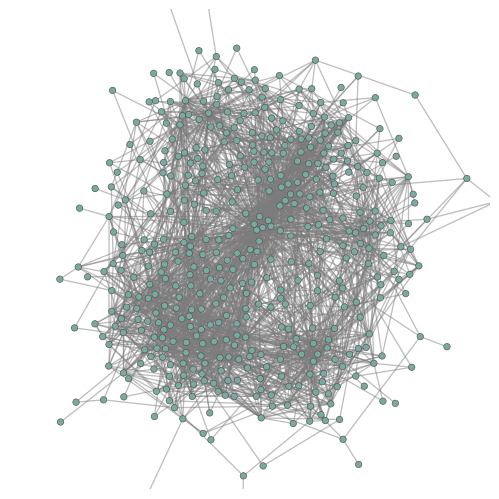

In [18]:
stylized_network, config = visualize(GG,)

In [19]:
U = pd.read_pickle("../public_data/UserInfo.pkl")
id2color = dict(zip(U.userid.values, U.PlotColor.values))
for k, v in GG.nodes(data=True):
    v["group"] = id2color[k]

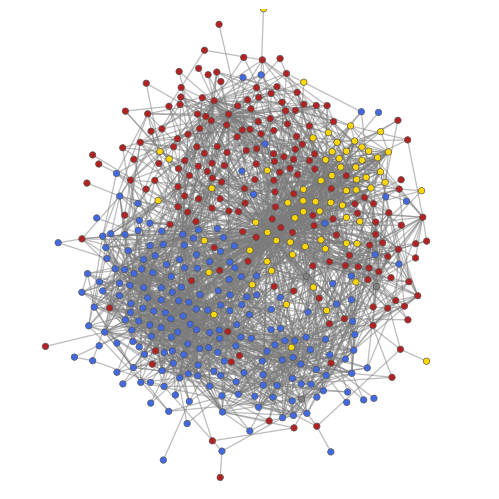

In [20]:
stylized_network, config = visualize(GG,port=2000)

### Activity Two
- Create a new column in U called "Degree," which denotes the degree of the node (userid). You will want to use G.degree()[n] where n is the userid.
- Group by User Type. Which group was the most popular during the pandemic?

In [22]:
# your code here.
U['Degree'] = U.userid.apply(lambda x: G.degree(x) if x in G else 0)
U.groupby('User_type')['Degree'].mean()

User_type
Democrat           12.286408
Health Official    18.397590
Independent         0.292683
Republican          8.118483
Name: Degree, dtype: float64